In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt

In [33]:
CINIC_10_FOLDER_PATH = 'CINIC-10'
IMAGE_PATH = f'{CINIC_10_FOLDER_PATH}\\test\\airplane\\cifar10-test-3.png'
NUMBER_OF_CLASSES = 10
LEARNING_RATE = 0.001
BATCH_SIZE = 64
DROPOUT = 0.25
EPOCHS = 5

In [34]:
print("Is gpu available: " + str(torch.cuda.is_available()))

Is gpu available: True


In [35]:
class SimpleCNN(nn.Module):
    name = "Simple cnn"

    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, NUMBER_OF_CLASSES)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [36]:
class AdvancedCNN(nn.Module):
    name = "Advanced cnn"

    def __init__(self):
        super(AdvancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(DROPOUT)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, NUMBER_OF_CLASSES)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [37]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.ImageFolder(f'{CINIC_10_FOLDER_PATH}/train', transform=transform)
test_dataset = datasets.ImageFolder(f'{CINIC_10_FOLDER_PATH}/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model1 = SimpleCNN()
optimizer1 = optim.Adam(model1.parameters(), lr=LEARNING_RATE)

model2 = AdvancedCNN()
optimizer2 = optim.Adam(model2.parameters(), lr=LEARNING_RATE)

criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train

In [38]:
def train(model, optimizer):
    model.to(device)

    for epoch in range(EPOCHS):
        model.train()
        images_processed = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            images_processed += len(images)
            if images_processed % 100 == 0:
                print(f'{model.name} epoch {epoch+1}/{EPOCHS}, Processed {images_processed}/{len(train_dataset)} images')

In [ ]:
train(model1, optimizer1)

In [ ]:
train(model2, optimizer2)

# Test

In [41]:
def test_and_plot(model):
    model.eval()
    class_correct = dict.fromkeys(test_loader.dataset.classes, 0)
    class_total = dict.fromkeys(test_loader.dataset.classes, 0)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            for label, prediction in zip(labels, predicted):
                if label == prediction:
                    class_correct[test_loader.dataset.classes[label]] += 1
                class_total[test_loader.dataset.classes[label]] += 1

    overall_correct = sum(class_correct.values())
    overall_total = sum(class_total.values())
    overall_accuracy = 100 * overall_correct / overall_total
    print(f'{model.name} overall accuracy on test set: {overall_accuracy:.2f}%')

    class_accuracies = {classname: 100 * class_correct[classname] / class_total[classname] 
                        for classname in class_correct}

    plt.figure(figsize=(10, 6))
    plt.bar(class_accuracies.keys(), class_accuracies.values(), color='blue')
    plt.xlabel('Class')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{model.name} accuracy per class')
    plt.xticks(rotation=45)
    plt.ylim([0, 100])
    plt.show()

Simple cnn overall accuracy on test set: 57.52%


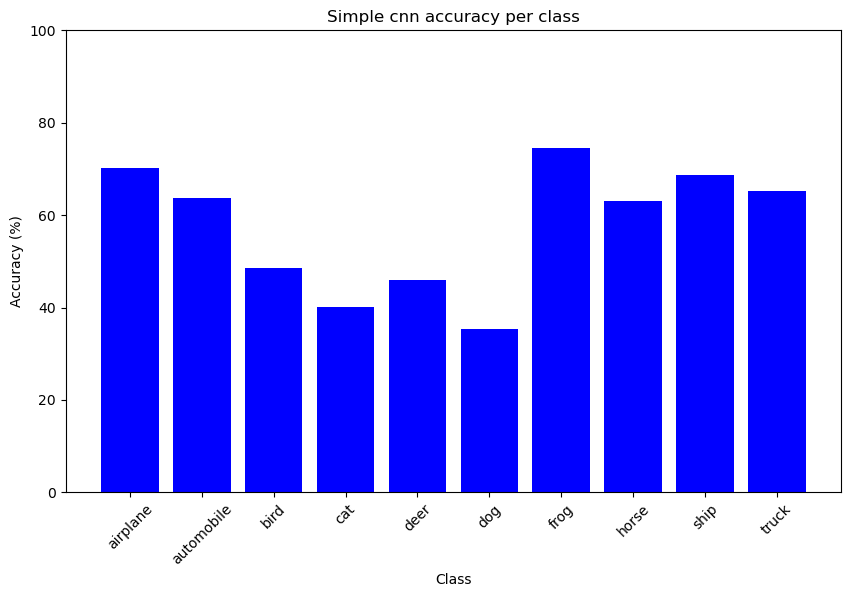

In [42]:
test_and_plot(model1)

Advanced cnn overall accuracy on test set: 62.90%


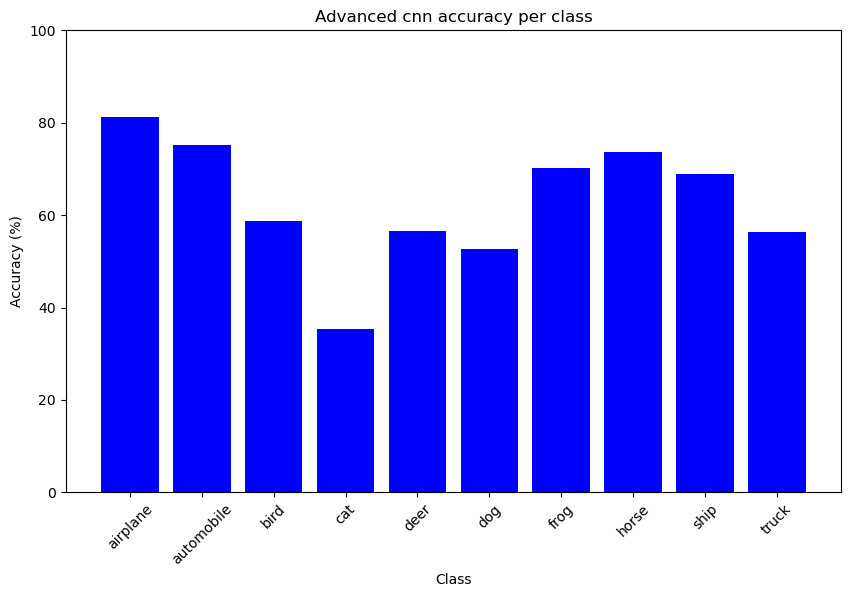

In [43]:
test_and_plot(model2)

# Single image

In [44]:
def predict_single_image(image_path, model):
    image = Image.open(image_path).convert('RGB')

    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    image = transform(image).unsqueeze(0)
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    class_name = test_dataset.classes[predicted.item()]
    print(f'{model.name} cnn predicted class: {class_name}')

In [45]:
predict_single_image(IMAGE_PATH, model1)

Simple cnn cnn predicted class: airplane


In [46]:
predict_single_image(IMAGE_PATH, model2)

Advanced cnn cnn predicted class: airplane
